# Boosting with Random Forest, ADABoost and XGBoost

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.metrics as sm
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import pylab as pl

### 1. Data Processing

#### a. Import the data

In [2]:
#Read the data
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)
adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### b. Assign the column names

In [3]:
# Create a list of column names
list_of_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital_status','occupation',\
                  'relationship','race','sex','capital-gain','capital-loss','hours-per-week',\
                  'native-country','salary']

#renaming the dataframe columns using the list_of_columns

adult.columns = list_of_columns

In [4]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### c. Check your dataframe shape

In [5]:
adult.shape

(32561, 15)

#### d) Drop the 3rd column from the data (it is referred to as "fnlwgt" on UCI's website and is not necessary in this homework)

In [6]:
adult.drop(['fnlwgt'], axis = 1, inplace = True)

#### e) Note: There are random values of  '?' that show up in the data - this is fine! These just refer to "unknown" and can be left as is. This data has no true NA values, so no need to check.

#### f) Use the .replace() method to make the following changes to the "salary" column

In [7]:
adult.salary.replace(to_replace=['<=50K', '>50K'], value = [0,1], inplace = True)
adult.head()

,age,workclass,education,education-num,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


#### g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary".

In [8]:
X = adult.drop(['salary'], axis=1)
y = adult['salary']

#print the shapes
X.shape, y.shape

((32561, 13), (32561,))

In [9]:
y.unique()

array([0, 1], dtype=int64)

#### i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use Pandas built-in method .get_dummies(). Pandas will automatically split out columns that are categorical. For now, just run across your full X dataframe.

In [10]:
X_encoded = pd.get_dummies(X)

In [11]:
X_encoded.shape

(32561, 107)

#### j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your X_train and X_test.

In [12]:
# Split the data into train and test by setting random state = 42
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Print the shape of X_train, X_test, y_train, y_test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22792, 107), (9769, 107), (22792,), (9769,))

### 2. Random Forest Classifier - Base Model:
Start by creating a simple Random Forest only using default parameters - this will let us compare Boosting methods to Random Forest in binary classification problems.

#### a) Use the RandomForestClassifier in sklearn. Fit your model on the training data.

In [13]:
#Create an instance of the Random forest classifier
rf = RandomForestClassifier(random_state=42)

In [14]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [15]:
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [16]:
y_score_rf = rf.predict_proba(X_test)
y_score_rf

array([[1.        , 0.        ],
       [0.34833333, 0.65166667],
       [0.251     , 0.749     ],
       ...,
       [1.        , 0.        ],
       [0.54219048, 0.45780952],
       [0.02      , 0.98      ]])

#### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [17]:
cm_train = sm.confusion_matrix(y_test,y_pred_rf)
cm_train

array([[6828,  627],
       [ 873, 1441]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

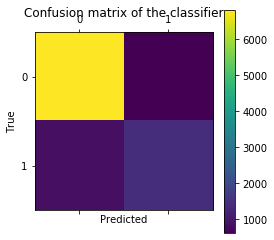

In [18]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [19]:
#Classification report
print(sm.classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7455
           1       0.70      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



#### d) Calculate the AUC score (we did this in HW #4 many times).

In [20]:
# limit to probability for class = 1
base_probs = rf.predict_proba(X_test)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_test, base_probs))

0.8889081826018049


#### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [21]:
featureImp= []
for feat, importance in zip(X_train.columns, rf.feature_importances_):
    temp = [feat, importance*100]
    featureImp.append(temp)
fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
#print (fT_df.sort_values('Importance', ascending = False))

fT_df = fT_df.sort_values('Importance', ascending = False)

#Print the top 5 features
fT_df[0:5]

,Feature,Importance
0,age,22.061979
4,hours-per-week,11.370445
2,capital-gain,9.857231
32,marital_status_Married-civ-spouse,7.508058
1,education-num,6.734544


#### f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

In [22]:
y_pred_train = rf.predict(X_train)

In [23]:
cm_train = sm.confusion_matrix(y_train,y_pred_train)
cm_train

array([[17103,   162],
       [  272,  5255]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

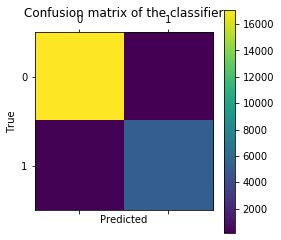

In [24]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [25]:
print(sm.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17265
           1       0.97      0.95      0.96      5527

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



In [26]:
# limit to probability for class = 1
base_probs_train = rf.predict_proba(X_train)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_train, base_probs_train))

0.9979123677457127


**Explanation** - There are clear signs of overfitting. The precision, recall, f1-score and roc_auc score are very high indicating overfitting.

### 3. AdaBoost Classifier - GridSearch:

#### a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

n_estimators: 100, 200, 300, 400  
learning_rate: 0.2,0.4,0.6,0.8,1, 1.2

In [27]:
param_grid = {
    'n_estimators':[100, 200, 300, 400, 500, 600],
    'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2, 1.4, 1.6]}


# create AdaBoost Classifier model 
abc = AdaBoostClassifier()

# Create gridsearch object with various combinations of parameters
abc_Grid = GridSearchCV(abc, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

In [28]:
abc_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.3min finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4,
                                           1.6],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='roc_auc', verbose=5)

In [29]:
abc_Grid.best_params_

{'learning_rate': 1.4, 'n_estimators': 600}

In [30]:
abc_Grid.best_estimator_

AdaBoostClassifier(learning_rate=1.4, n_estimators=600)

#### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [31]:
abc = AdaBoostClassifier(learning_rate=1.4, n_estimators=600)

In [32]:
abc.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1.4, n_estimators=600)

In [33]:
y_pred_abc = abc.predict(X_test)

In [34]:
y_score_abc = abc.predict_proba(X_test)
y_score_abc

array([[0.50138358, 0.49861642],
       [0.49990481, 0.50009519],
       [0.49984398, 0.50015602],
       ...,
       [0.5015885 , 0.4984115 ],
       [0.49998272, 0.50001728],
       [0.49591034, 0.50408966]])

#### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [35]:
cm_train = sm.confusion_matrix(y_test,y_pred_abc)
cm_train

array([[7009,  446],
       [ 801, 1513]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

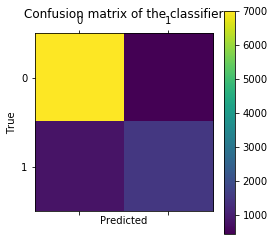

In [36]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [37]:
print(sm.classification_report(y_test,y_pred_abc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.77      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



#### d) Calculate the AUC score

In [38]:
# limit to probability for class = 1
base_probs = abc.predict_proba(X_test)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_test, base_probs))

0.9253470984361948


#### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [39]:
featureImp= []
for feat, importance in zip(X_train.columns, abc.feature_importances_):
    temp = [feat, importance*100]
    featureImp.append(temp)
fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
#print (fT_df.sort_values('Importance', ascending = False))

fT_df = fT_df.sort_values('Importance', ascending = False)

#Print the top 5 features
fT_df[0:5]

,Feature,Importance
2,capital-gain,32.666667
3,capital-loss,31.000000
0,age,11.166667
4,hours-per-week,7.000000
1,education-num,1.333333


#### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [40]:
y_pred_train = abc.predict(X_train)

In [41]:
cm_train = sm.confusion_matrix(y_train,y_pred_train)
cm_train

array([[16278,   987],
       [ 1874,  3653]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

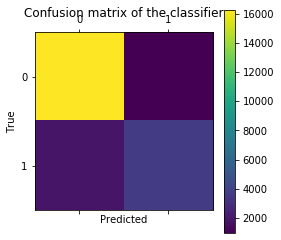

In [42]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [43]:
print(sm.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.79      0.66      0.72      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792



In [44]:
# limit to probability for class = 1
base_probs_train = abc.predict_proba(X_train)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_train, base_probs_train))

0.934171375011783


The train roc_auc_score is 0.93 and the test roc_auc_score is 0.92. This model is performing really well and giving good results. Since the train and test roc_auc_scores are very close, there is no overfitting in the model

### 4. Gradient Boosting Classifier - GridSearch:

#### a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following hyperparameters:

n_estimators: 100,200, 300 & 400  
learning_rate: choose 3 learning rates of your choice  
max_depth: 1, 2 (you can try deeper, but remember part of the value of boosting stems from minimal complexity of trees)

In [45]:
param_grid = {
    'n_estimators':[100, 200, 300, 400, 500, 600],
    'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2, 1.4, 1.6],
    'max_depth':[1,2]}


# create AdaBoost Classifier model 
gbc = GradientBoostingClassifier()

# Create gridsearch object with various combinations of parameters
gbc_Grid = GridSearchCV(gbc, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

In [46]:
gbc_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  8.8min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4,
                                           1.6],
                         'max_depth': [1, 2],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='roc_auc', verbose=5)

In [47]:
gbc_Grid.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 600}

In [48]:
gbc_Grid.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=600)

#### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [49]:
gbc = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=600)

In [50]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=600)

In [51]:
y_pred_abc = gbc.predict(X_test)

In [52]:
y_score_abc = gbc.predict_proba(X_test)
y_score_abc

array([[0.99182525, 0.00817475],
       [0.40552204, 0.59447796],
       [0.25550522, 0.74449478],
       ...,
       [0.99378374, 0.00621626],
       [0.44282462, 0.55717538],
       [0.00299407, 0.99700593]])

#### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [53]:
cm_train = sm.confusion_matrix(y_test,y_pred_abc)
cm_train

array([[7027,  428],
       [ 796, 1518]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

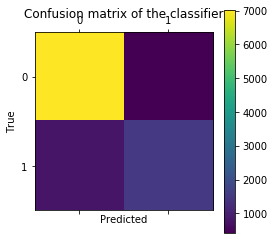

In [54]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [55]:
print(sm.classification_report(y_test,y_pred_abc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.66      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



#### d) Calculate the AUC score

In [56]:
# limit to probability for class = 1
base_probs_grb = gbc.predict_proba(X_test)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_test, base_probs_grb))

0.926545211922645


#### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [57]:
featureImp= []
for feat, importance in zip(X_train.columns, gbc.feature_importances_):
    temp = [feat, importance*100]
    featureImp.append(temp)
fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
#print (fT_df.sort_values('Importance', ascending = False))

fT_df = fT_df.sort_values('Importance', ascending = False)

#Print the top 5 features
fT_df[0:5]

,Feature,Importance
32,marital_status_Married-civ-spouse,35.518824
2,capital-gain,21.935102
1,education-num,17.174106
3,capital-loss,6.675301
0,age,6.273419


#### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [58]:
y_pred_train = gbc.predict(X_train)

In [59]:
cm_train = sm.confusion_matrix(y_train,y_pred_train)
cm_train

array([[16388,   877],
       [ 1755,  3772]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

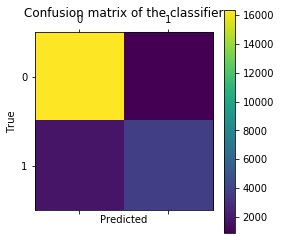

In [60]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [61]:
print(sm.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     17265
           1       0.81      0.68      0.74      5527

    accuracy                           0.88     22792
   macro avg       0.86      0.82      0.83     22792
weighted avg       0.88      0.88      0.88     22792



In [62]:
# limit to probability for class = 1
base_probs_train_grb = gbc.predict_proba(X_train)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_train, base_probs_train_grb))

0.942522700477151


**Explanation** - This model doesnt indicate overfitting as the train and test scores are very close.

### 5. XGBoost - RandomizedSearchCV

In [63]:
#Install XGBOOST
!pip install xgboost

#### Repeat 4(a) - 4(f) with xgboost and RandomizedSearchCV.
4a use the following parameters: 

n_estimators: 100-1000 in increments of 50  (i.e. 100,150,200,.....1000)  
learning_rate: 0.1 - 1.6 in increments of 0.1  
max_depth: 1, 2  
gamma: 0 - 5 in increments of 0.25  

In [64]:
import xgboost as xgb

n_estimator_list = [i for i in range(100, 1000, 50)]
learning_rate_list = [i for i in np.arange(0.1,1.6,0.1)]
gamma_list = [i for i in np.arange(0,5,0.25)]

param_grid = {
    'n_estimators':n_estimator_list,
    'learning_rate':learning_rate_list,
    'max_depth':[1,2],
    'gamma':gamma_list}


# create AdaBoost Classifier model 
clf_xgb = xgb.XGBClassifier()

# Create gridsearch object with various combinations of parameters
clf_Grid = RandomizedSearchCV(clf_xgb, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

In [65]:
clf_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:  1.4min remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
C:\Users\shash\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                                  2.5, 2.75, 3.0, 3.25, 3.5,
                                                  3.75, 4.0, 4.25, 4.5, 4.75],
                         

In [66]:
clf_Grid.best_params_

{'n_estimators': 950,
 'max_depth': 1,
 'learning_rate': 1.5000000000000002,
 'gamma': 0.25}

In [67]:
clf_Grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.5000000000000002, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=950, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [68]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7000000000000001, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
clf.fit(X_train, y_train)

[00:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7000000000000001, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
y_pred_abc = clf.predict(X_test)

C:\Users\shash\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [71]:
y_score_abc = clf.predict_proba(X_test)
y_score_abc

array([[9.9418646e-01, 5.8135679e-03],
       [5.0513250e-01, 4.9486750e-01],
       [3.6331326e-01, 6.3668674e-01],
       ...,
       [9.9746794e-01, 2.5320759e-03],
       [4.7526127e-01, 5.2473873e-01],
       [5.1367283e-04, 9.9948633e-01]], dtype=float32)

#### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [72]:
cm_train = sm.confusion_matrix(y_test,y_pred_abc)
cm_train

array([[7021,  434],
       [ 814, 1500]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

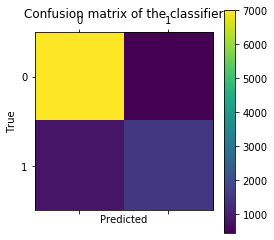

In [73]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [74]:
print(sm.classification_report(y_test,y_pred_abc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



#### d) Calculate the AUC score

In [75]:
# limit to probability for class = 1
base_probs = clf.predict_proba(X_test)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_test, base_probs))

0.9245494285215758


#### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

In [76]:
featureImp= []
for feat, importance in zip(X_train.columns, clf.feature_importances_):
    temp = [feat, importance*100]
    featureImp.append(temp)
fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
#print (fT_df.sort_values('Importance', ascending = False))

fT_df = fT_df.sort_values('Importance', ascending = False)

#Print the top 5 features
fT_df[0:5]

,Feature,Importance
32,marital_status_Married-civ-spouse,34.122345
1,education-num,12.822095
2,capital-gain,4.422371
41,occupation_Exec-managerial,3.863535
45,occupation_Other-service,3.043144


#### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [77]:
y_pred_train = clf.predict(X_train)

C:\Users\shash\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [78]:
cm_train = sm.confusion_matrix(y_train,y_pred_train)
cm_train

array([[16347,   918],
       [ 1835,  3692]], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

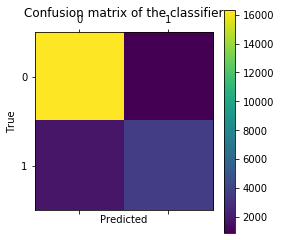

In [79]:
fig = plt.figure(figsize=(20,20))
pl.matshow(cm_train)
pl.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
pl.colorbar()
plt.show()

In [80]:
print(sm.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17265
           1       0.80      0.67      0.73      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



In [81]:
# limit to probability for class = 1
base_probs_train = clf.predict_proba(X_train)[:,1]
# calculate roc_auc_score
print(sm.roc_auc_score(y_train, base_probs_train))

0.9378244052798019


**Explanation** - The classifier is not performing as well as GradientBoost. There is no overfitting and this model is performing similar to ADABOOST.

### 6. Moving into Conceptual Problems:

#### a) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

**Answer** -  
The parameter alpha is the predictor's weight. It is calculated using the following formula
    $$\alpha_j = \eta log \frac{1-r_j}{r_j}$$
where η is the learning rate hyperparameter. The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.  
Next the instance weights are updated and the misclassified instances are boosted. In this way the alpha parameter is used to boost the weight of misclassified instances and lowers the weight of correctly classified instances using the alpha parameter.

#### b) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

**Answer** -  
In AdaBoost, the alpha parameter is used to boost the weights of incorrectly classified instances. After every instance the weights are recalculated and incorrectly classified instances are boosted using alpha parameter. Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on).
To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes. The formula for prediction is 

$$\hat y(x) = argmax_k \sum^N_{j=1}\alpha_j$$
where N is the number of predictors

#### c) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

**Answer** -  
The max_depth parameters defines how deep the decision tree can grow. It is very important to tune this parameter as low depth can lead to underfit on the data and derive any trend in the data. On the other hand, the deep trees can overfit on the training data leading to high variance in the model.

#### d) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

**Answer** - 
The features 'education-num' and 'captial-gain' comes up in all the models (Random Forest, AdaBoost, GradientBoost and XGBoost). The feature 'age' comes up in 3 of the models. This makes sense as education and capital gain do determine the salaries and income of the people and the models are also using these to determine the salary 

#### e) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

**Answer** -
The model GradientBoost gave the best performance based on the classification report. The rest of the parameters are same between AdaBoost, GradientBoost and XGBoost, however GradientBoost has better recall score for class of 1. The overall accuracy of GradientBoost is 0.87. The precision, recall  and f1-score for class 0 is 0.90, 0.94 and 0.92 respectively and for class 1 is 0.78, 0.66, 0.71 respectively.

The best hyperparamters for GradientBoost that came after grid search are: 
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 600}

#### f) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.


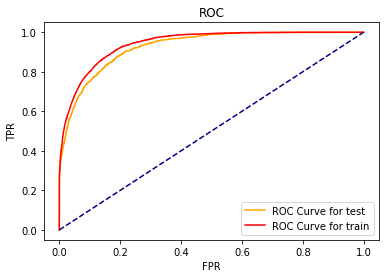

In [82]:
# Plot roc curves
fpr, tpr, thresholds = roc_curve(y_test, base_probs_grb)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, base_probs_train_grb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color = 'orange', label = "ROC Curve for test")
plt.plot(fpr_train, tpr_train, color = 'red', label = "ROC Curve for train")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel ('FPR')
plt.ylabel ('TPR')
plt.title ('ROC')
plt.legend(loc='lower right')
plt.show()

**Answer** - ROC stands for Receiver Operator Characteristics. Depending on the threshold, confusion matrix paramaters will change. ROC maps false positive rate on X-axis and Recall on the Y-axis for every threshold and that helps to decide which threshold gives the best result.